# Feature extraction and reverse image search

This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

For an introduction into feature extraction, see the previous notebook `feature_extraction.ipynb`.

### Prepare a dataset

You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

This notebook will use an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. You may have already downloaded this dataset from the previous notebook, `7a_transfer_learning.ipynb`. If not, please download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

We'll start by importing the relevant Keras libraries that we'll be using.

In [1]:
#%tensorflow_version 1.x

In [2]:
# Setup tensorflow GPUs
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-02-19 11:16:52.931952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 11:16:52.956291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 11:16:52.956566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# Let's look at the processor we're running
!nvidia-smi

Sat Feb 19 11:16:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8    10W /  N/A |    470MiB /  8192MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
# Can start here, load data to do classification
# Need to run load_image above

import pickle
from keras.preprocessing import image

#from google.colab import drive
#drive.mount('/content/gdrive')
#[images, pca_features, pca, imageToCategory] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/CalTechFeatures.p', 'rb'))
#[images, pca_features, pca, imageToCategory] = pickle.load(open('../../../101_ObjectCategories/CalTechFeatures.p', 'rb'))
[images, pca_features, pca, pca_features_full, pcaFull, imageToCategory] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/CalTechFeatures.p', 'rb'))

print(dir())
print(len(images))

['In', 'Model', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', '_dh', '_exit_code', '_i', '_i1', '_i2', '_i3', '_i4', '_i5', '_i6', '_ih', '_ii', '_iii', '_oh', 'decode_predictions', 'device', 'exit', 'get_ipython', 'gpu_devices', 'image', 'imageToCategory', 'images', 'keras', 'load_image', 'np', 'os', 'pca', 'pcaFull', 'pca_features', 'pca_features_full', 'pickle', 'plt', 'preprocess_input', 'quit', 'tf']
7442


Now let's see what the PCA version of the feature vector above looks like.

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

7442
<class 'dict'>
<class 'list'>
7442
1708
ewer


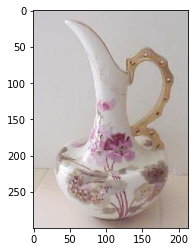

In [7]:
import random
from keras.preprocessing import image

print(len(imageToCategory))
print(type(imageToCategory))
print(type(images))
print(len(images))

# grab a random query image
query_image_idx = int(len(images) * random.random())
print(query_image_idx)
print(imageToCategory[images[query_image_idx]])

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [8]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [9]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

ewer
ewer
ewer
ewer
ewer


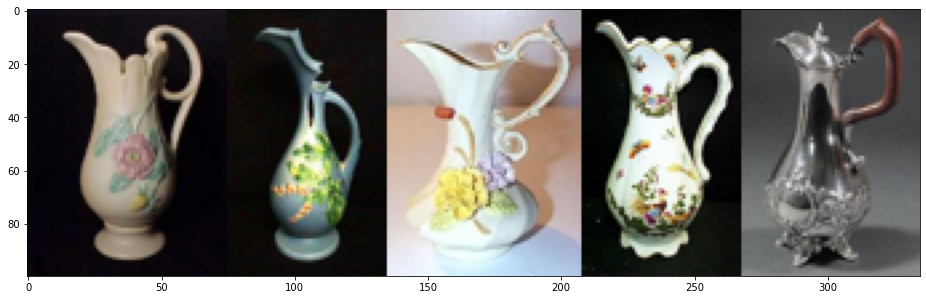

In [10]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    print(imageToCategory[images[idx]])
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


For convenience, we'll automate this process by defining the function `get_closest_images`, which will compute the cosine distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [11]:
def get_closest_images(query_image_idx, pca_feat, num_results=5):
    distances = [ distance.cosine(pca_feat[query_image_idx], feat) for feat in pca_feat ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


So now we can do our lookups like this:

query category= pyramid
   match category= pyramid
   match category= pyramid
   match category= pyramid
   match category= pyramid
   match category= joshua_tree


Text(0.5, 1.0, 'result images')

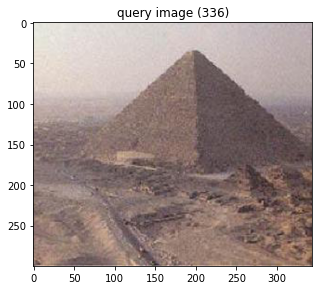

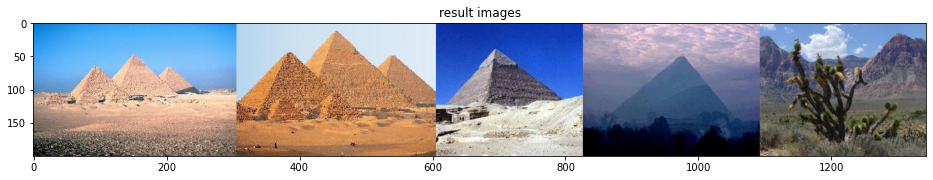

In [12]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
print('query category=', imageToCategory[images[query_image_idx]])
idx_closest = get_closest_images(query_image_idx, pca_features)
for ii in idx_closest:
  print('   match category=', imageToCategory[images[ii]])

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

And again...

query category= revolver
   match category= revolver
   match category= revolver
   match category= revolver
   match category= revolver
   match category= revolver


Text(0.5, 1.0, 'result images')

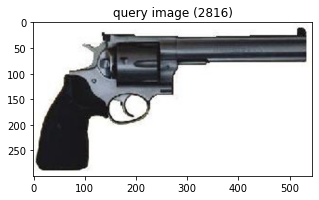

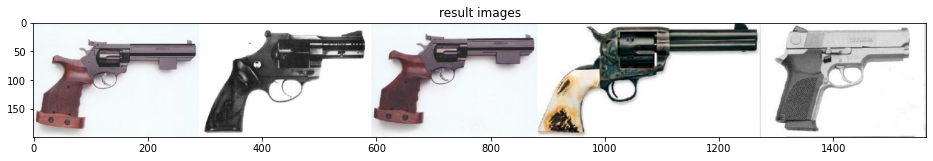

In [13]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
print('query category=', imageToCategory[images[query_image_idx]])
idx_closest = get_closest_images(query_image_idx, pca_features)
for ii in idx_closest:
  print('   match category=', imageToCategory[images[ii]])

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [14]:
import time

def getClosestPerImage(images, imageToCategory, pca_feats, N=5):

    # Return the top N *closest* images for each image
    t0 = time.time()

    closestForImagePath = {}
    for i, image_path in enumerate(images):
        # Find category of query image
        queryCategory=imageToCategory[image_path]

        # Get N closest images and store in dictionary
        idx_closest = get_closest_images(i, pca_feats, N)
        closestForImagePath[image_path] = idx_closest

        if i % 500 == 0:
            print("analyzing image %d / %d" % (i, len(images)))

    elap = time.time() - t0;
    print("Total time: %5.4f seconds." % elap)

    return closestForImagePath

In [15]:
def getStatsPerCategory(images, imageToCategory, closestForImagePath, K):

    # Compute precision @ K for each category
    sumRelevantByCategory = {}
    sumCorrectByCategory = {}
    totalByCategory = {}
    for i, image_path in enumerate(images):
        queryCategory=imageToCategory[image_path]

        # If we have not seen category yet, add it to dictionary
        if queryCategory not in sumCorrectByCategory:
            sumRelevantByCategory[queryCategory] = 0
            sumCorrectByCategory[queryCategory] = 0
            totalByCategory[queryCategory] = 0

        # Compute precision @ K
        idx_closest = closestForImagePath[image_path]
        for k in range(K):
            if queryCategory == imageToCategory[images[idx_closest[k]]]:
                sumWas = sumCorrectByCategory[queryCategory]
                sumCorrectByCategory[queryCategory] = sumWas + 1
                break;
        # Get sum of relevant items
        for k in range(5):
            if queryCategory == imageToCategory[images[idx_closest[k]]]:
                sumWas = sumRelevantByCategory[queryCategory]
                sumRelevantByCategory[queryCategory] = sumWas + 1

        totalWas = totalByCategory[queryCategory]
        totalByCategory[queryCategory] = totalWas + 1

    return sumRelevantByCategory, sumCorrectByCategory, totalByCategory

In [16]:
def getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory):
    sumCorrect = 0
    sumTotal = 0
    labels = []
    precisions = []
    recalls = []
    sumPrecision = 0.0
    sumRecall = 0.0
    for key in sumCorrectByCategory.keys():
        precision = sumCorrectByCategory[key]/totalByCategory[key]
        recall = sumCorrectByCategory[key]/sumRelevantByCategory[key]

        sumCorrect = sumCorrect + sumCorrectByCategory[key]
        sumTotal = sumTotal + totalByCategory[key]
        labels.append(key)
        precisions.append(precision)
        recalls.append(recall)
        
        sumPrecision += precision
        sumRecall += recall

    avgPrecision = sumPrecision/len(labels)
    avgRecall = sumRecall/len(labels)
    print("avg precision= %4.2f, avg recall=%4.2f" % (avgPrecision, avgRecall))
    
    return avgPrecision, avgRecall, labels, precisions, recalls

In [17]:
def getAvgPrecision(images, imageToCategory, closestForImagePath, K):

    # Compute precision @ K for each category
    precisionByCategory = {}
    sumPrecision = 0.0
    for i, image_path in enumerate(images):
        queryCategory=imageToCategory[image_path]

        # If we have not seen category yet, add it to dictionary
        if queryCategory not in sumCorrectByCategory:
            precisionByCategory[queryCategory] = []
            recallByCategory[queryCategory] = []

        # Compute precision @ K for this image
        idx_closest = closestForImagePath[image_path]
        sumRelevant = 0
        for k in range(K):
            if queryCategory == imageToCategory[images[idx_closest[k]]]:
                sumRelevant += 1
        precisionByCategory[queryCategory].append(sumRelevant/K)
        sumPrecision += sumRelevant/K

    return sumPrecision/len(images), sumCorrectByCategory, totalByCategory

In [18]:
#closestForImagePath = getClosestPerImage(images, imageToCategory, pca_features, N=5)

In [19]:
#closestForImagePathFull = getClosestPerImage(images, imageToCategory, pca_features_full, N=5)

In [20]:
# Here we save/read things that take a long time to run.
import pickle

#pickle.dump([closestForImagePathFull, closestForImagePath], open('./gdrive/MyDrive/101_ObjectCategories/metrics300_4000.p', 'wb'))
[closestForImagePathFull, closestForImagePath] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/metrics300_4000.p', 'rb'))

In [21]:
# Create confusion matrix
categories = sorted(set(imageToCategory.values()))
print('num categories=', str(len(categories)))
print('num images=', str(len(closestForImagePath.keys())))

categoryToIdx = {}
idxToCategory = {}
for idx, category in enumerate(categories):
    categoryToIdx[category] = idx
    idxToCategory[idx] = category

print(categoryToIdx)
print(idxToCategory)

totalForCategory = {}
cm = np.zeros([len(categories), len(categories)], dtype=int)
count=0
for image_path in images:
    count += 1
    cat1 = imageToCategory[image_path]
    if cat1 not in totalForCategory:
        #print(str(count), ' ', cat1)
        totalForCategory[cat1] = 0
    totalForCategory[cat1] = totalForCategory[cat1] + 1        
    
    idx1 = categoryToIdx[cat1]
    closest = closestForImagePath[image_path]
    for i in closest:
        cat2 = imageToCategory[images[i]]
        idx2 = categoryToIdx[cat2]
        cm[idx1][idx2] += 1
        
i,j = np.unravel_index(cm.argmax(), cm.shape)
print('Max:', str(i), ' ', str(j), ' ', str(cm[i][j]), ' ', idxToCategory[i])
print(cm)
print(totalForCategory)
for i in range(len(categories)):
    cat = idxToCategory[i]
    print(i, ' ', cat, ' ', totalForCategory[cat])

num categories= 99
num images= 7442
{'Faces': 0, 'Leopards': 1, 'Motorbikes': 2, 'accordion': 3, 'airplanes': 4, 'anchor': 5, 'ant': 6, 'barrel': 7, 'bass': 8, 'beaver': 9, 'binocular': 10, 'bonsai': 11, 'brain': 12, 'brontosaurus': 13, 'buddha': 14, 'butterfly': 15, 'camera': 16, 'cannon': 17, 'car_side': 18, 'ceiling_fan': 19, 'cellphone': 20, 'chair': 21, 'chandelier': 22, 'cougar_body': 23, 'cougar_face': 24, 'crab': 25, 'crocodile': 26, 'crocodile_head': 27, 'cup': 28, 'dalmatian': 29, 'dollar_bill': 30, 'dolphin': 31, 'dragonfly': 32, 'electric_guitar': 33, 'elephant': 34, 'emu': 35, 'euphonium': 36, 'ewer': 37, 'ferry': 38, 'flamingo': 39, 'flamingo_head': 40, 'garfield': 41, 'gerenuk': 42, 'gramophone': 43, 'grand_piano': 44, 'hawksbill': 45, 'headphone': 46, 'hedgehog': 47, 'helicopter': 48, 'ibis': 49, 'inline_skate': 50, 'joshua_tree': 51, 'kangaroo': 52, 'ketch': 53, 'lamp': 54, 'laptop': 55, 'llama': 56, 'lobster': 57, 'lotus': 58, 'mandolin': 59, 'mayfly': 60, 'menorah': 

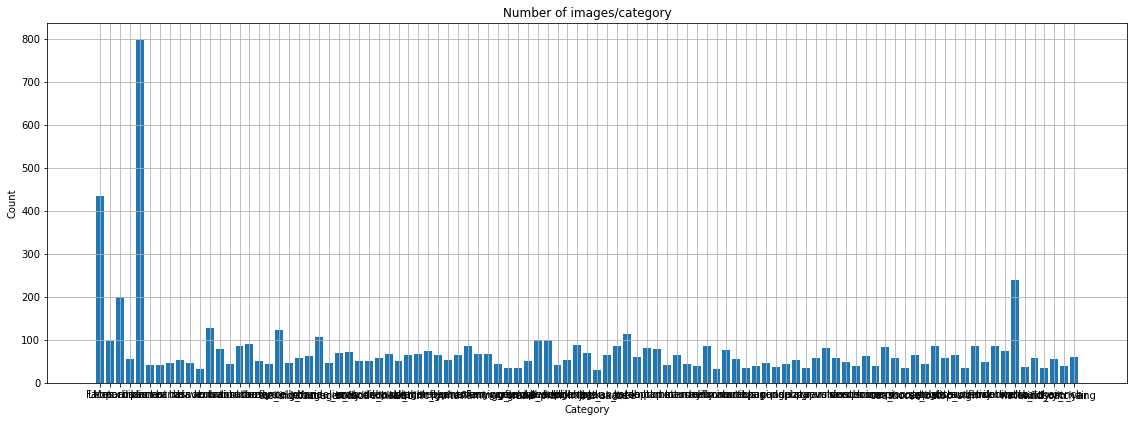

In [22]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

totals = np.zeros(len(categories))
for cat in categories:
    i = categoryToIdx[cat]
    totals[i] = totalForCategory[cat]

ax = fig.add_axes([0,0,1,1])
ax.bar(categories, totals)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.title('Number of images/category')
plt.grid()

plt.show()

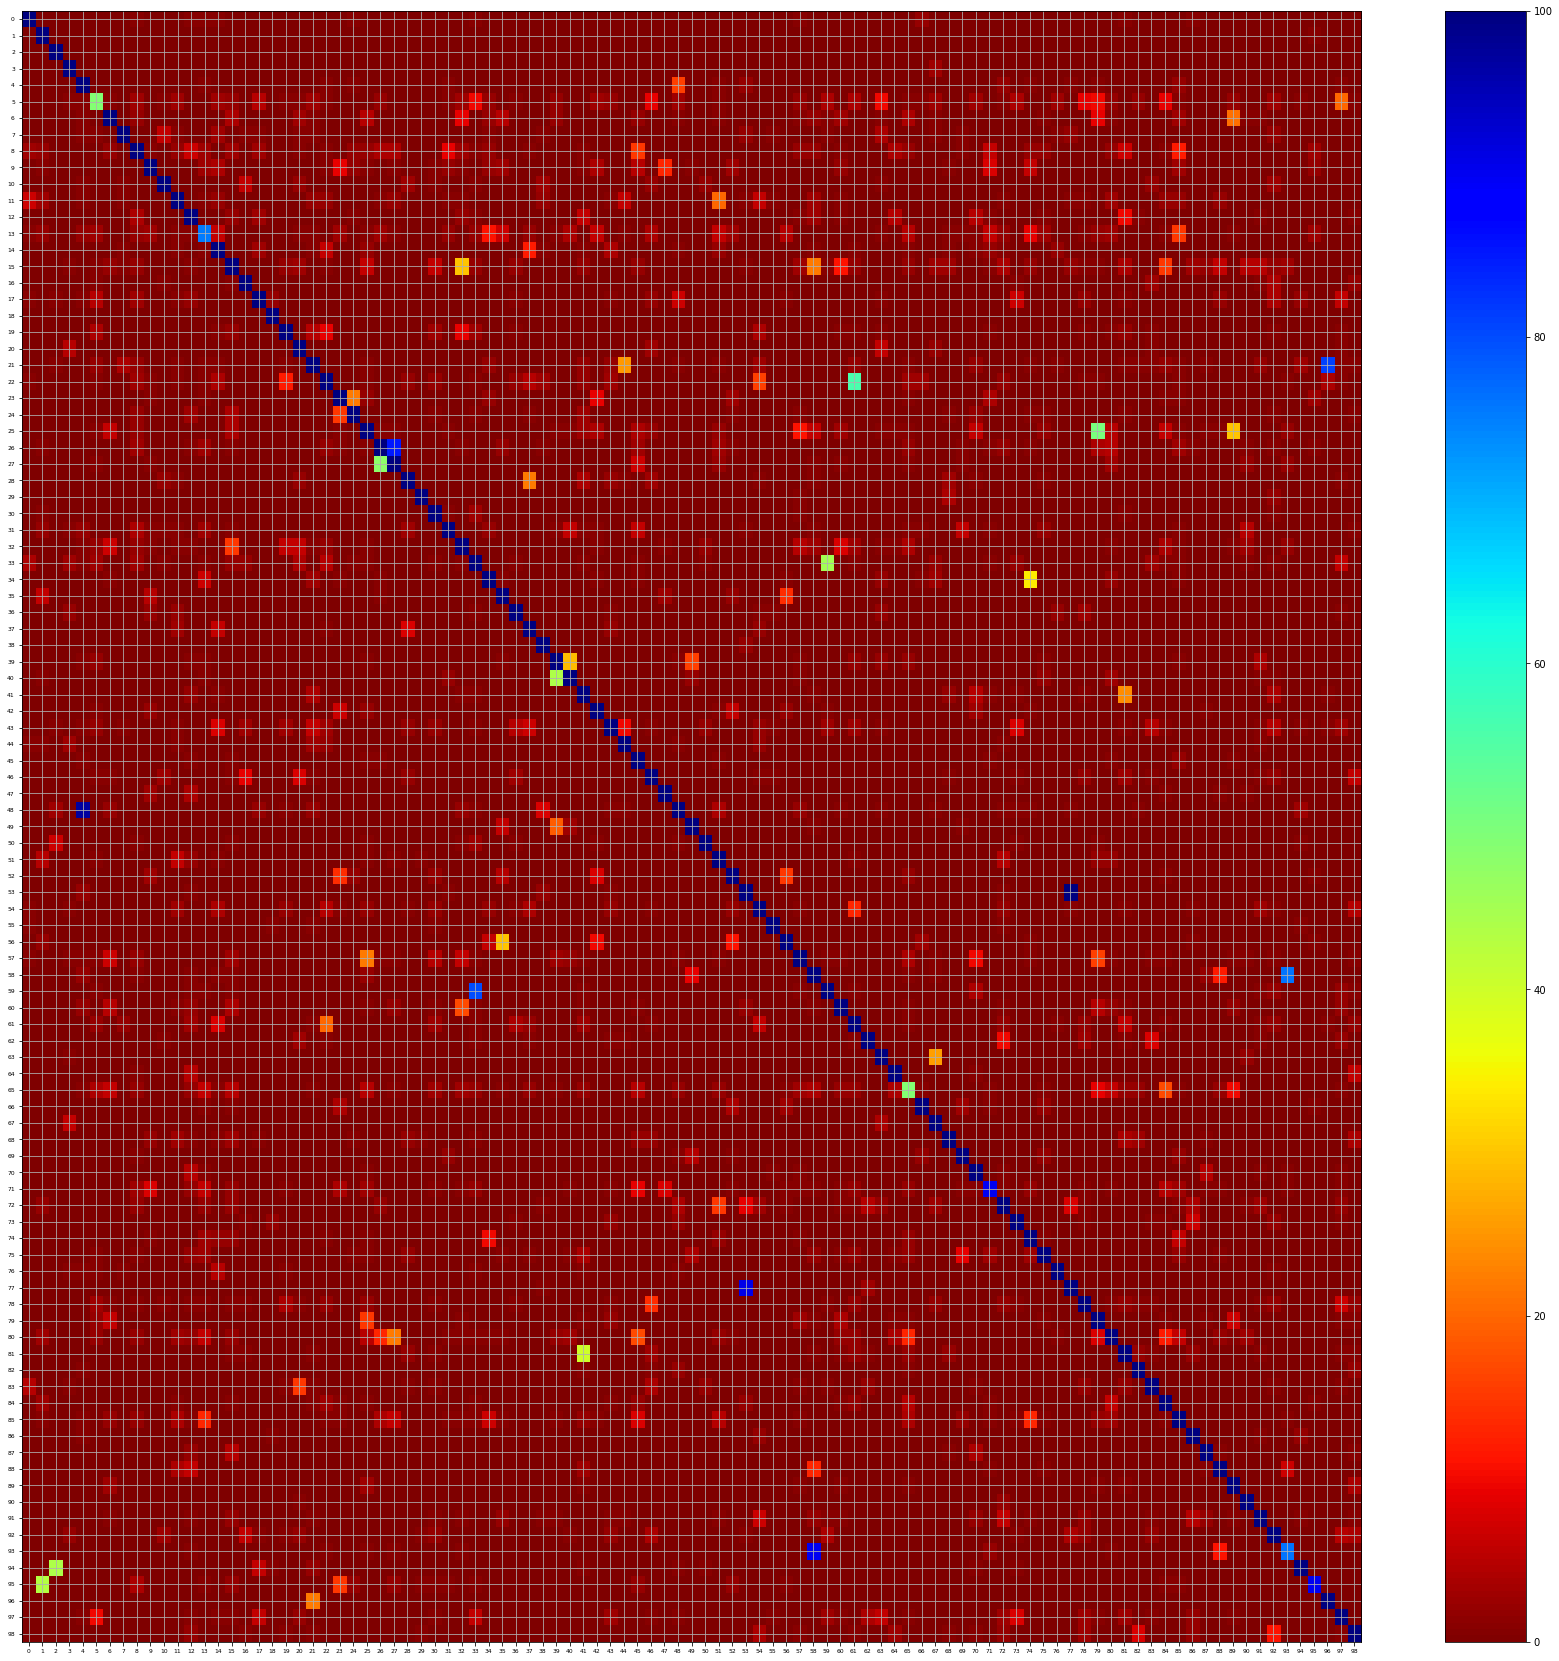

In [23]:
N = len(categories)

ticks=np.linspace(0, N-1, num=N)
plt.rcParams["figure.figsize"] = (30,30)

#clim = np.amax(cm)
#plt.imshow(cm, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=clim)
plt.imshow(cm, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=100)
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)

plt.show()

Max of all elements= 3959
Max of off-diagonal elements= 128


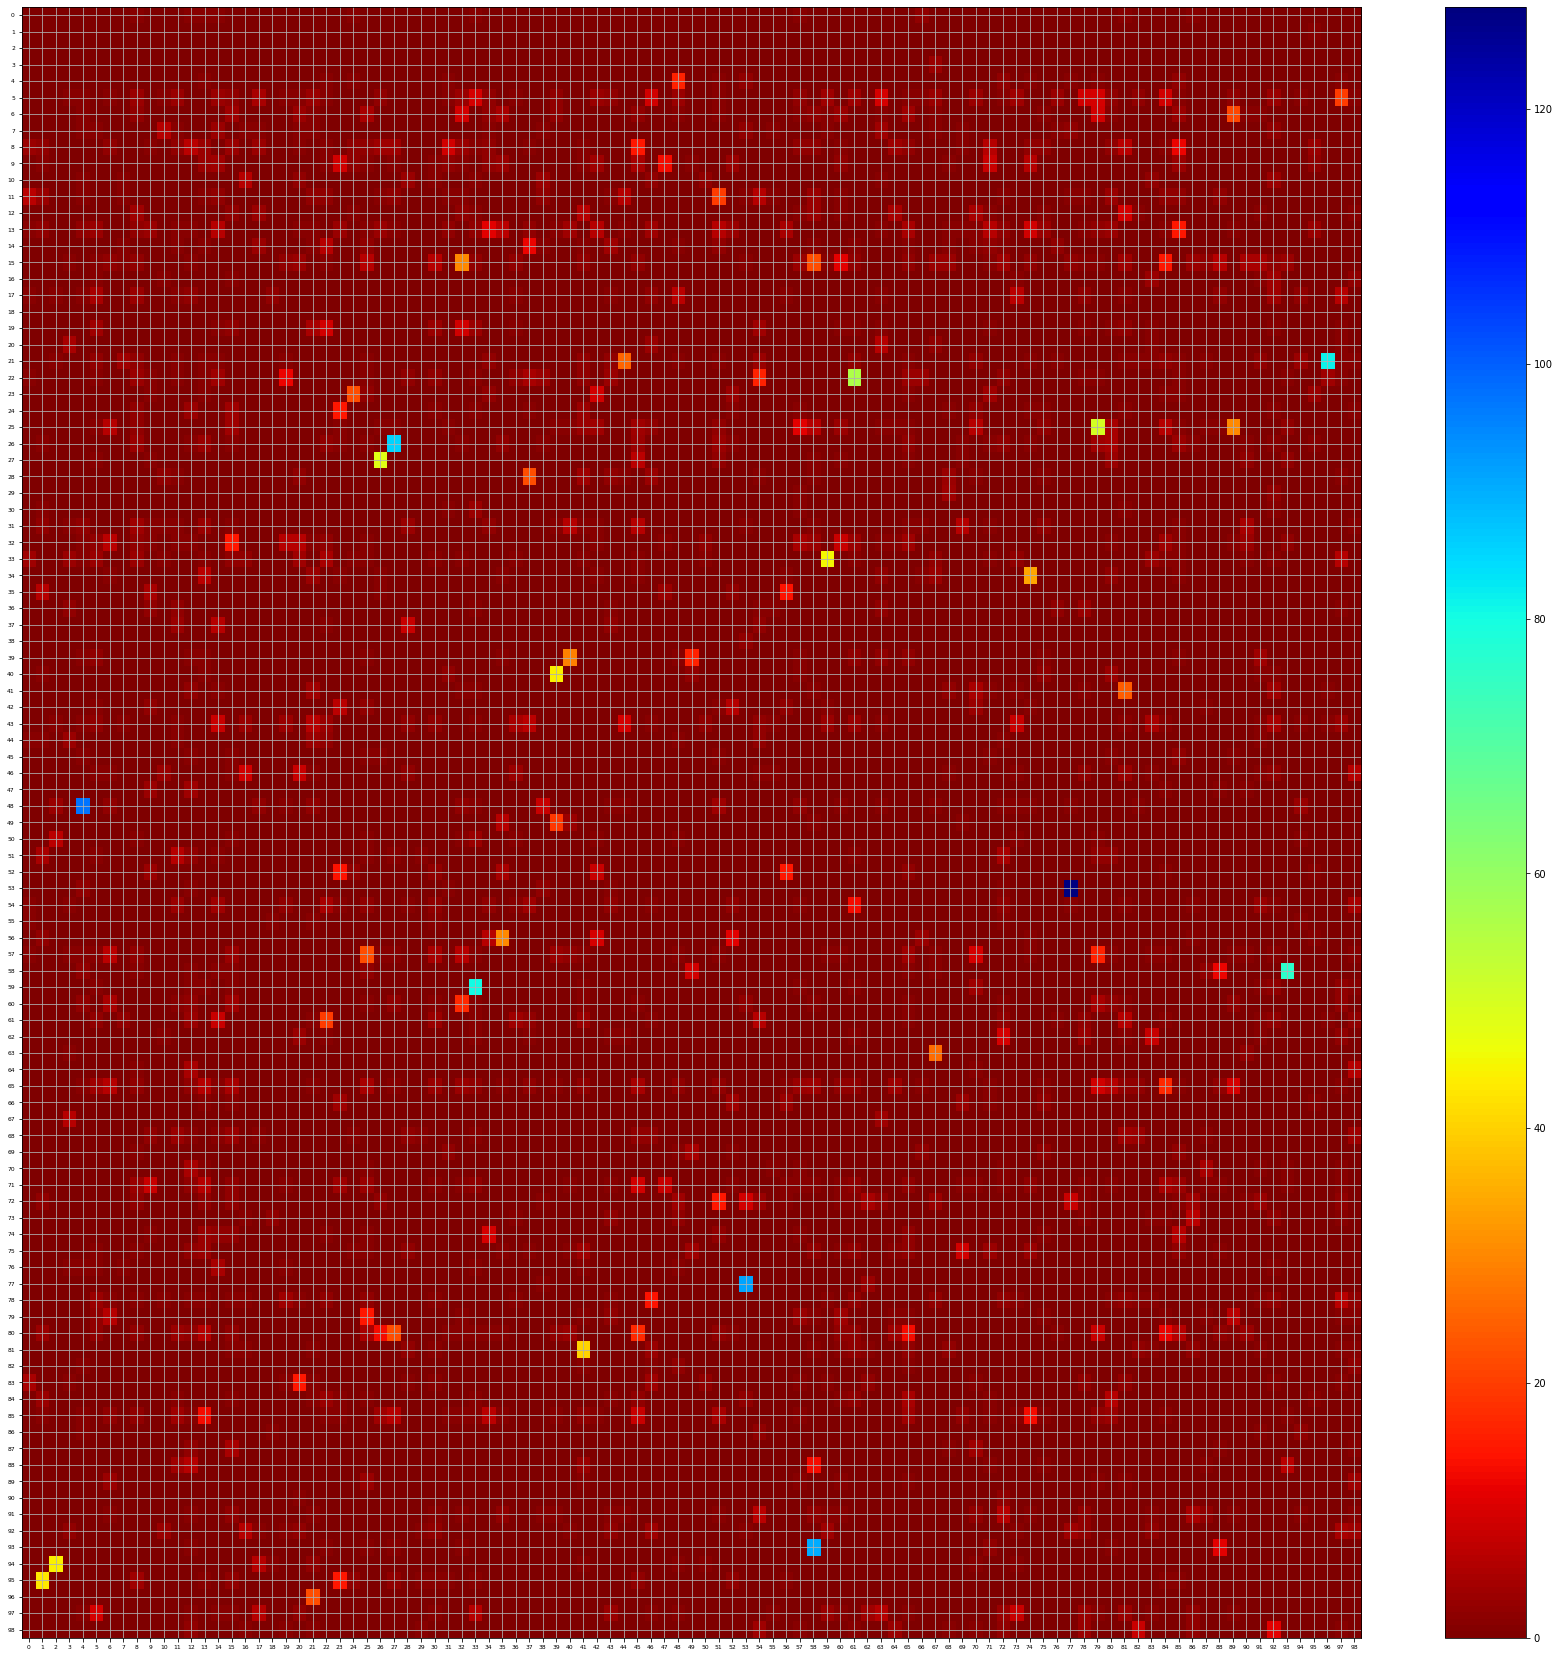

In [24]:
ticks=np.linspace(0, N-1, num=N)
plt.rcParams["figure.figsize"] = (30,30)

cm2 = np.copy(cm)
for i in range(N):
    cm2[i][i] = 0

clim2 = np.amax(cm2)
print('Max of all elements=', str(np.amax(cm)))
print('Max of off-diagonal elements=', str(clim2))

plt.imshow(cm2, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=clim2)
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)

plt.show()

In [25]:
# Look at categories with misclassification
N = len(categories)
threshold = 30
for i in range (N-1):
    for j in range(i+1, N):
        if cm[i][j] > threshold:
            print(str(i), ', ', str(j), ', ', str(cm[i][j]), ' (', categories[i], ', ', categories[j], ')')

21 ,  96 ,  81  ( chair ,  windsor_chair )
22 ,  61 ,  56  ( chandelier ,  menorah )
25 ,  79 ,  50  ( crab ,  scorpion )
26 ,  27 ,  85  ( crocodile ,  crocodile_head )
33 ,  59 ,  45  ( electric_guitar ,  mandolin )
34 ,  74 ,  34  ( elephant ,  rhino )
53 ,  77 ,  128  ( ketch ,  schooner )
58 ,  93 ,  76  ( lotus ,  water_lilly )


In [26]:
x = np.arange(5.0) + 1
ap300 = np.zeros([5,1])
ar300 = np.zeros([5,1])
print(x)
print(ap300)

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePath, 1)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap300[0] = ap
ar300[0] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePath, 2)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap300[1] = ap
ar300[1] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePath, 3)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap300[2] = ap
ar300[2] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePath, 4)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap300[3] = ap
ar300[3] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePath, 5)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap300[4] = ap
ar300[4] = ar

[1. 2. 3. 4. 5.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
avg precision= 0.84, avg recall=0.22
avg precision= 0.89, avg recall=0.23
avg precision= 0.92, avg recall=0.24
avg precision= 0.93, avg recall=0.24
avg precision= 0.94, avg recall=0.25


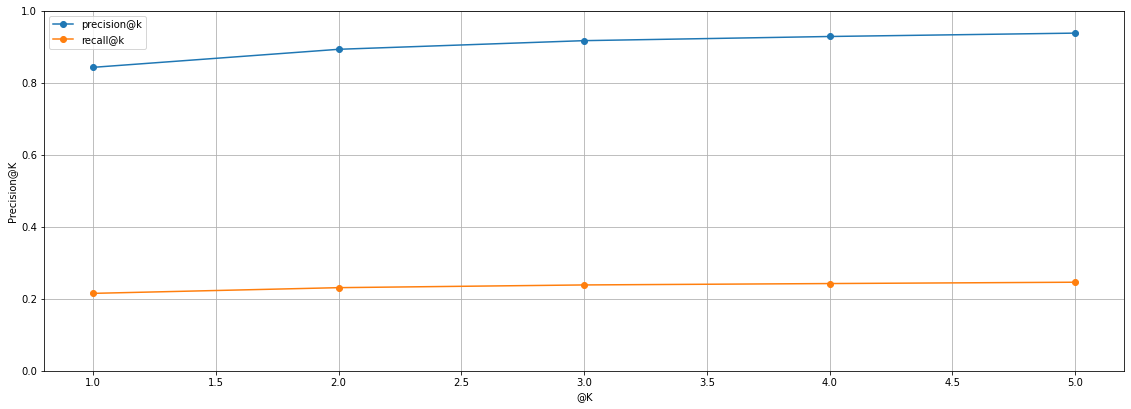

In [27]:
import matplotlib.pyplot as plt
xi = x.astype(int)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0., 1.])
ax.plot(xi, ap300, marker='o')
ax.plot(xi, ar300, marker='o')
ax.set_xlabel('@K')
ax.set_ylabel('Precision@K')
#ax.set_title('Precision@K by K')
ax.legend(['precision@k', 'recall@k'])
plt.grid()

plt.show()

In [28]:
ap4000 = np.zeros([5,1])
ar4000 = np.zeros([5,1])

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePathFull, 1)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap4000[0] = ap
ar4000[0] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePathFull, 2)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap4000[1] = ap
ar4000[1] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePathFull, 3)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap4000[2] = ap
ar4000[2] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePathFull, 4)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap4000[3] = ap
ar4000[3] = ar

sumRelevantByCategory, sumCorrectByCategory, totalByCategory = getStatsPerCategory(images, imageToCategory, closestForImagePathFull, 5)
ap,ar,l,p,r = getAccuracyPerCategory(sumRelevantByCategory, sumCorrectByCategory, totalByCategory)
ap4000[4] = ap
ar4000[4] = ar

avg precision= 0.84, avg recall=0.22
avg precision= 0.89, avg recall=0.23
avg precision= 0.92, avg recall=0.24
avg precision= 0.93, avg recall=0.24
avg precision= 0.94, avg recall=0.25


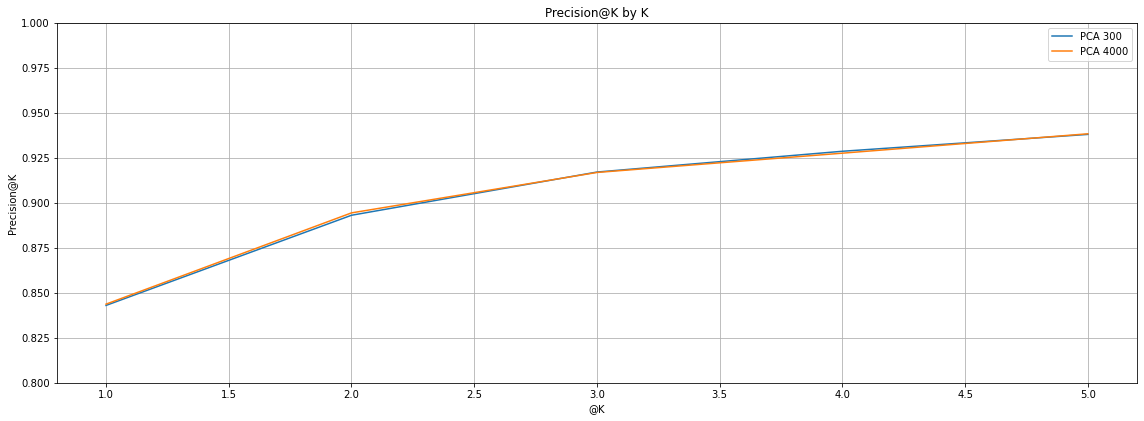

In [29]:
import matplotlib.pyplot as plt
xi = x.astype(int)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0.8, 1.])
ax.plot(xi, ap300)
ax.plot(xi, ap4000)
ax.set_xlabel('@K')
ax.set_ylabel('Precision@K')
ax.set_title('Precision@K by K')
ax.legend(['PCA 300', 'PCA 4000'])
plt.grid()

plt.show()

In [30]:
sumCorrect = 0
sumTotal = 0
labels = []
accuracies = []
for key in sumCorrectByCategory.keys():
  accuracy = sumCorrectByCategory[key]/totalByCategory[key]
  sumCorrect = sumCorrect + sumCorrectByCategory[key]
  sumTotal = sumTotal + totalByCategory[key]
  print("%s = %4.2f" % (key, accuracy))
  labels.append(key)
  accuracies.append(accuracy)

print("\nOverall score= %4.2f" % (sumCorrect/sumTotal))

schooner = 0.98
cup = 0.93
cougar_body = 0.89
chair = 0.85
tick = 0.96
binocular = 1.00
pyramid = 0.91
ibis = 0.99
brain = 0.97
llama = 0.96
euphonium = 0.97
saxophone = 1.00
inline_skate = 0.94
okapi = 0.95
pizza = 0.98
lotus = 0.94
Leopards = 1.00
butterfly = 0.84
soccer_ball = 1.00
buddha = 0.94
emu = 0.96
chandelier = 0.98
beaver = 0.89
gerenuk = 0.97
stegosaurus = 0.97
flamingo_head = 0.98
elephant = 0.94
cellphone = 1.00
ewer = 0.98
stop_sign = 1.00
sunflower = 0.96
wheelchair = 0.92
dragonfly = 0.97
wild_cat = 0.82
accordion = 1.00
panda = 1.00
Motorbikes = 1.00
octopus = 0.57
cougar_face = 0.93
ferry = 1.00
cannon = 0.86
ketch = 0.95
lamp = 0.95
revolver = 0.98
gramophone = 0.84
crocodile = 0.86
wrench = 0.82
crocodile_head = 0.92
windsor_chair = 1.00
car_side = 1.00
joshua_tree = 0.95
metronome = 0.91
starfish = 0.97
snoopy = 0.89
pigeon = 1.00
lobster = 0.78
water_lilly = 1.00
sea_horse = 0.84
grand_piano = 0.99
watch = 0.99
rhino = 0.98
brontosaurus = 0.67
yin_yang = 0.93
an

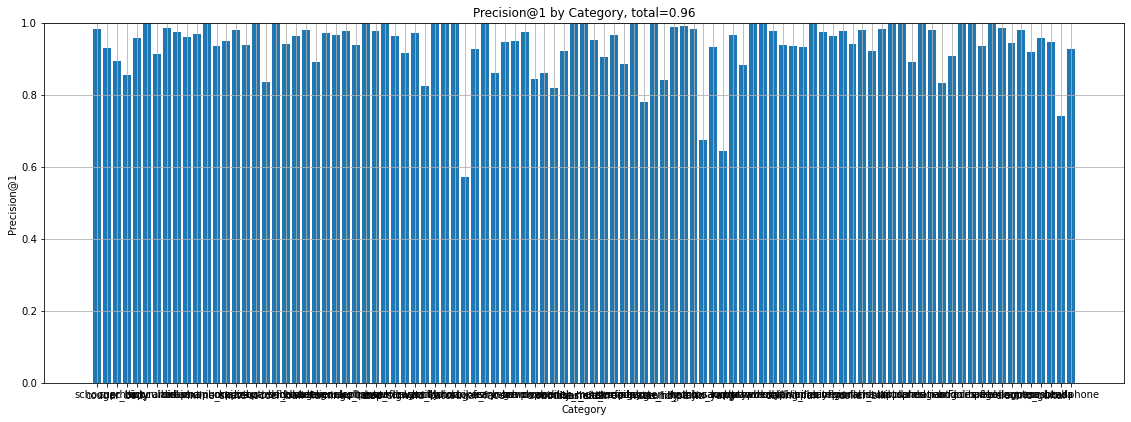

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 1])
ax.bar(labels, accuracies)
ax.set_xlabel('Category')
ax.set_ylabel('Precision@1')
ax.set_title('Precision@1 by Category, total=%4.2f' % (sumCorrect/sumTotal))
plt.grid()

plt.show()

In [32]:
sumCorrect = 0
sumTotal = 0
labels = []
accuracies = []
for key in sumCorrectByCategory.keys():
  accuracy = sumCorrectByCategory[key]/totalByCategory[key]
  sumCorrect = sumCorrect + sumCorrectByCategory[key]
  sumTotal = sumTotal + totalByCategory[key]
  print("%s = %4.2f" % (key, accuracy))
  labels.append(key)
  accuracies.append(accuracy)

print("\nOverall score= %4.2f" % (sumCorrect/sumTotal))

schooner = 0.98
cup = 0.93
cougar_body = 0.89
chair = 0.85
tick = 0.96
binocular = 1.00
pyramid = 0.91
ibis = 0.99
brain = 0.97
llama = 0.96
euphonium = 0.97
saxophone = 1.00
inline_skate = 0.94
okapi = 0.95
pizza = 0.98
lotus = 0.94
Leopards = 1.00
butterfly = 0.84
soccer_ball = 1.00
buddha = 0.94
emu = 0.96
chandelier = 0.98
beaver = 0.89
gerenuk = 0.97
stegosaurus = 0.97
flamingo_head = 0.98
elephant = 0.94
cellphone = 1.00
ewer = 0.98
stop_sign = 1.00
sunflower = 0.96
wheelchair = 0.92
dragonfly = 0.97
wild_cat = 0.82
accordion = 1.00
panda = 1.00
Motorbikes = 1.00
octopus = 0.57
cougar_face = 0.93
ferry = 1.00
cannon = 0.86
ketch = 0.95
lamp = 0.95
revolver = 0.98
gramophone = 0.84
crocodile = 0.86
wrench = 0.82
crocodile_head = 0.92
windsor_chair = 1.00
car_side = 1.00
joshua_tree = 0.95
metronome = 0.91
starfish = 0.97
snoopy = 0.89
pigeon = 1.00
lobster = 0.78
water_lilly = 1.00
sea_horse = 0.84
grand_piano = 0.99
watch = 0.99
rhino = 0.98
brontosaurus = 0.67
yin_yang = 0.93
an

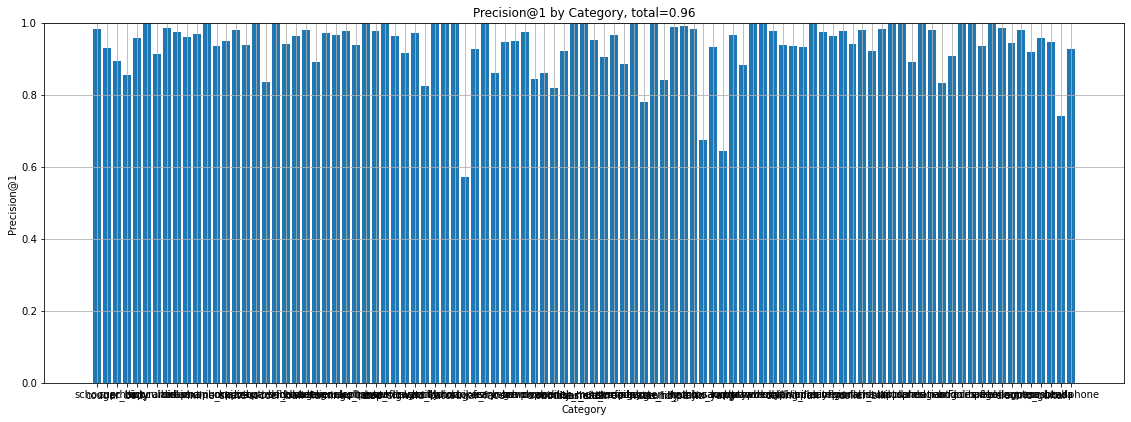

In [33]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 1])
ax.bar(labels, accuracies)
ax.set_xlabel('Category')
ax.set_ylabel('Precision@1')
ax.set_title('Precision@1 by Category, total=%4.2f' % (sumCorrect/sumTotal))
plt.grid()

plt.show()

In [34]:
from sklearn import metrics
y_true = []
y_pred = []

for image_path in images:
    cat1 = imageToCategory[image_path]
    closest = closestForImagePath[image_path]
    for i in closest:
        y_true.append(cat1)
        y_pred.append(imageToCategory[images[i]])

f1 = metrics.f1_score(y_true, y_pred, average='macro')
print(f1)
mac = metrics.precision_score(y_true, y_pred, average='macro')
print(mac)
mic = metrics.recall_score(y_true, y_pred, average='micro')
print(mic)
wei = metrics.f1_score(y_true, y_pred, average='weighted')
print(wei)
mac2 = metrics.fbeta_score(y_true, y_pred, average='macro', beta=0.5)
print(mac2)
#f = metrics.precision_recall_fscore_support(y_true, y_pred, beta=0.5, average=None)
#print(f)
cm2 = metrics.multilabel_confusion_matrix(y_true, y_pred)
print(cm2.shape)

0.8007726824806697
0.8084243887716934
0.8543671056167697
0.850339299247856
0.8043213484962561
(99, 2, 2)


In [ ]:
# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(featureList)
feature_list_compressed = pca.transform(featureList)

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

tsne_results =
TSNE(n_components=2,verbose=1,metric='euclidean')
    .fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c =
               selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()